In [1]:
import torch
import matplotlib.pyplot as plt
from torch import optim, distributions, nn
from tqdm.notebook import tqdm
import gpzoo
from gpzoo.kernels import NSF_RBF
from gpzoo.gp import GaussianPrior, SVGP
from gpzoo.likelihoods import PNMF, NSF2, Hybrid_NSF2
from gpzoo.utilities import train_hybrid, train_hybrid_batched, anndata_to_train_val, plot_factors, rescale_spatial_coords
import squidpy as sq
import numpy as np
from sklearn.decomposition import NMF
import scanpy as sc
import random

from gpzoo.utilities import regularized_nmf, dims_autocorr
from matplotlib.animation import FuncAnimation
from matplotlib import animation
import pickle

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
ad = sc.read_h5ad("/gladstone/engelhardt/home/lchumpitaz/gitclones/nsf-paper/simulations/bm_sp/data/S1.h5ad")


In [3]:
ad = ad[:,:80]
X = ad.obsm["spatial"]
D,Dval = anndata_to_train_val(ad, layer="counts", train_frac=0.8,
                                         flip_yaxis=False)
Ntr,J = D["Y"].shape

Xtr = D["X"]
ad = ad[:Ntr,:]

In [4]:
ad

View of AnnData object with n_obs × n_vars = 1037 × 80
    obsm: 'nsfac', 'spatial', 'spfac'
    varm: 'nsload', 'spload'
    layers: 'counts'

In [5]:
D['Y'].shape

(1037, 80)

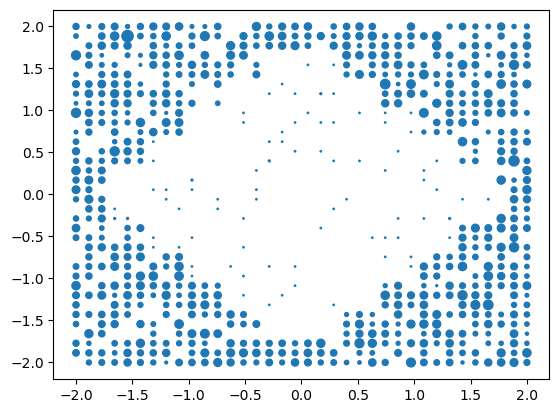

In [6]:
plt.scatter(Xtr[:,0], Xtr[:,1], s=D['Y'][:, 0], )

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [8]:
factors, loadings = regularized_nmf(D['Y'], L=4, shrinkage=0.2, max_iter = 200, solver='mu', init='nndsvdar', beta_loss='kullback-leibler', random_state=0)

In [9]:
moran_idx, moranI = dims_autocorr(factors, D['X'])
# factors=factors[:, moran_idx]
# loadings=loadings[:, moran_idx]

In [10]:
X = torch.tensor(Xtr).type(torch.float)
Y = torch.tensor(D['Y'].T).type(torch.float)


In [11]:
# M = 500
# L = 4
# idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)
# kernel = NSF_RBF(L=L, sigma=1.0, lengthscale=0.1)
# all_factors = torch.tensor(factors[:, :L].T)[:, :, None]
# Kzx = kernel.forward(X[idx], X)
# Kzz = kernel.forward(X[idx], X[idx])
# Kxz = torch.transpose(Kzx, -2, -1)
# mu = Kzz@torch.pinverse(Kzx@Kxz) @ Kzx @all_factors

# factors_inter = torch.squeeze(Kxz @ torch.pinverse(Kzz)@mu)
# plot_factors(torch.exp(factors_inter).detach().numpy(), Xtr, moran_idx=None, ax=None, size=2, s=5, alpha=1)

In [12]:
def build_model(Y, M=23, L=4):
    
    Z = torch.cartesian_prod(torch.linspace(-2, 2, M), torch.linspace(-2, 2, M), )

    
    # idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)
    
    
    
    kernel = NSF_RBF(L=L, sigma=1.0, lengthscale=0.1)
    gp = SVGP(kernel, M=(M**2), jitter=1e-3)

    print('here')

    Kzx = kernel.forward(Z, X)
    Kxz = torch.transpose(Kzx, -2, -1)
    Kzz = kernel.forward(Z, Z)
    print('here')
    

    all_factors = torch.tensor(factors.T)[:, :, None]
    mu = Kzz@torch.pinverse(Kzx@Kxz) @ Kzx @ (all_factors[:L])

    print('here')
    
    
    # gp.mu = nn.Parameter(torch.randn((L, M)).type(torch.float))
    
    gp.mu = nn.Parameter(torch.squeeze(mu).clone().detach()).type(torch.float)
    
    Lu = 1e-2*torch.eye(M**2).expand(L, M**2, M**2)
    gp.Lu = nn.Parameter(Lu.clone().detach())
    
    gp.Z = nn.Parameter(Z, requires_grad=False)

    
    gaussian_prior = GaussianPrior(Y, L=L-1)
    gaussian_prior.mean = nn.Parameter(torch.zeros(L-1, len(X)).type(torch.float))

    model = Hybrid_NSF2(gp, gaussian_prior, Y, L=L, T=L-1)

    model.sf.W = nn.Parameter(torch.tensor(loadings[:, :L]).type(torch.float))

    
    model.cf.W = nn.Parameter(torch.ones(len(Y), L-1))


    model.cf.prior.scale_pf = 1e-1
    

    
    
    # if not new_model:
    #     model.load_state_dict(torch.load('slideseq_mggp_nsf.pth'))
    
    #     with open("slideseq_mggp_nsf_means.pth", "rb") as fp:   
    #         means = pickle.load(fp)
    
    #     with open("slideseq_mggp_nsf_scales.pth", "rb") as fp:   
    #         scales = pickle.load(fp)
    
    #     with open("slideseq_mggp_nsf_idxs.pth", "rb") as fp:   
    #         idxs = pickle.load(fp)
    
    
    model.to(device)
    return model

In [13]:
def build_model_scratch(Y, M=500, L=4):
    
    
    idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)
    kernel = NSF_RBF(L=L, sigma=1.0, lengthscale=1.0)
    gp = SVGP(kernel, M=M, jitter=1e-2)
    gp.mu = nn.Parameter(torch.randn((L, M)).type(torch.float))
    

    Lu = 1e-2*torch.eye(M).expand(L, M, M)
    gp.Lu = nn.Parameter(Lu.clone().detach())
    gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=False)

    
    gaussian_prior = GaussianPrior(Y, L=L-1)
    model = Hybrid_NSF2(gp, gaussian_prior, Y, L=L, T=L-1)
    model.cf.prior.scale_pf = 1e-2
    model.to(device)
    return model

In [14]:
model1 = build_model(Y, M=23)
# model2 = build_model(Y, M=250)
# model3 = build_model(Y, M=500)
# model4 = build_model(Y, M=1000)

here
here
here


In [15]:
X_train = X.to(device)
Y_train = Y.to(device)

In [16]:
def model_grads(model):
    model.sf.prior.kernel.sigma.requires_grad = False

    model.sf.prior.kernel.lengthscale.requires_grad = True
    model.sf.prior.Z.requires_grad=True
    model.sf.prior.mu.requires_grad=True
    model.sf.prior.Lu.requires_grad=True
    model.sf.W.requires_grad=True

    
    model.cf.W.requires_grad=False
    model.cf.prior.mean.requires_grad=False

    model.V.requires_grad=False

In [17]:
with torch.no_grad():
    # model1.cf.W = nn.Parameter(torch.zeros(len(Y), 3))
    model1.cf.prior.scale_pf = 1e-1
    # model1.sf.prior.kernel.sigma.view(-1)[::1] = 0.8
    # model1.sf.prior.kernel.lengthscale.view(-1)[::1] = 0.24
    # model1.V.view(-1)[::1] = 1.0

In [18]:
# with torch.no_grad():
#     # model1.cf.prior.mean[0].view(-1)[::1]=-10
#     # model1.cf.prior.mean[1].view(-1)[::1]=-10
#     # model1.cf.prior.mean[2].view(-1)[::1]=-10
#     model1.sf.prior.mu[0].view(-1)[::1]*=1.1
#     # model1.sf.prior.mu[1].view(-1)[::1]*=1.5
#     # model1.sf.prior.mu[3].view(-1)[::1]*=1.5
#     model1.cf.prior.scale_pf = 1e-1

In [19]:
model_grads(model1)
# model_grads(model2)
# model_grads(model3)
# model_grads(model4)

In [20]:
optimizer1 = optim.Adam(filter(lambda p: p.requires_grad, model1.parameters()), lr=1e-3)
# optimizer2 = optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=5e-3)
# optimizer3 = optim.Adam(filter(lambda p: p.requires_grad, model3.parameters()), lr=5e-3)
# optimizer4 = optim.Adam(filter(lambda p: p.requires_grad, model4.parameters()), lr=5e-3)

In [21]:
def train(model, optimizer, X, y, device, steps=200, E=20, **kwargs):
    losses = []
    
    means = []
    scales = []
    
    for it in tqdm(range(steps)):
                
        optimizer.zero_grad()
        pY, qF, qU, pU, qF2, pF2 = model.forward(X=X, E=E, **kwargs)

        logpY = y*torch.log(pY.rate) - pY.rate
        # logpY = pY.log_prob(y)

        ELBO = (logpY).mean(axis=0).sum()
        KL1 = distributions.kl_divergence(qU, pU)
        KL2 = distributions.kl_divergence(qF2, pF2)


        ELBO -= torch.sum(KL1)
        ELBO -= torch.sum(KL2)

        loss = -ELBO
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if (it%10)==0:
            means.append(torch.exp(qF.mean.detach().cpu()).numpy())
            scales.append(qF.scale.detach().cpu().numpy())
    
    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()
        
    return losses, means, scales

In [22]:
steps = 10*1000
model1.to(device)

Hybrid_NSF2(
  (sf): PoissonFactorization(
    (prior): SVGP(
      (kernel): NSF_RBF()
    )
  )
  (cf): PoissonFactorization(
    (prior): GaussianPrior()
  )
)

In [23]:
# model1.sf.prior.jitter = 1e-2

In [24]:
%time losses1, means1, scales1 = train(model1, optimizer1, X_train, Y_train, device, steps=steps, E=1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 10min 13s, sys: 3.78 s, total: 10min 16s
Wall time: 7min 41s


In [25]:

# %time losses2, means2, scales2 = train(model2, optimizer2, X_train, Y_train, device, steps=steps, E=50)

In [26]:
# %time losses3, means3, scales3 = train(model3, optimizer3, X_train, Y_train, device, steps=steps, E=50)

In [27]:
# %time losses4, means4, scales4 = train(model4, optimizer4, X_train, Y_train, device, steps=steps, E=50)

In [28]:
# plt.title('Negative ELBO')
# plt.plot(losses1, label='M=100')
# plt.plot(losses2, label='M=250')
# plt.plot(losses3, label='M=500')
# plt.plot(losses4, label='M=1000')
# plt.legend()

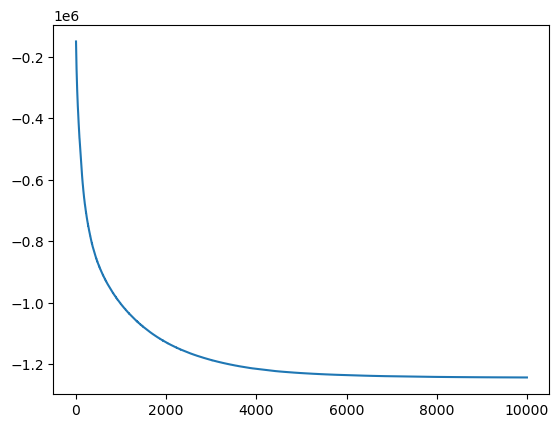

In [29]:
plt.plot(losses1)

In [30]:
def plot_factors(factors, X, moran_idx=None, ax=None, size=7, alpha=0.8, s=0.1, names=None):

    
    if moran_idx is not None:
        factors = factors[moran_idx]
        if names is not None:
            names = names[moran_idx]

    L = len(factors)

    if ax is None:
        fig, ax = plt.subplots(1, 4, figsize=(size*4, size), tight_layout=True)
        
    for i in range(L):
        plt.subplot(1, 4, i+1)
        
        curr_ax = ax[i]
        max_val = np.percentile(factors[i], 90)
        min_val = np.percentile(factors[i], 10)
        
        
        curr_ax.scatter(X[:, 0], X[:,1], c=factors[i], vmin=min_val, vmax=max_val, alpha=alpha, cmap='Blues', s=s)

        curr_ax.invert_yaxis()
        if names is not None:
            curr_ax.set_title(names[i], x=0.03, y=.88, fontsize="small", c="white",
                     ha="left", va="top")
        curr_ax.set_xticks([])
        curr_ax.set_yticks([])
        curr_ax.set_facecolor('xkcd:gray')

In [31]:
model1.sf.prior.kernel.lengthscale

Parameter containing:
tensor([[[0.1597]],

        [[0.1611]],

        [[0.1576]],

        [[0.1408]]], device='cuda:0', requires_grad=True)

In [32]:
model1.sf.prior.kernel.sigma

Parameter containing:
tensor([[[1.]],

        [[1.]],

        [[1.]],

        [[1.]]], device='cuda:0')

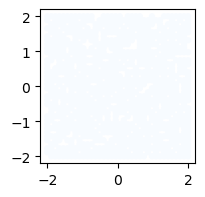

In [33]:
plt.figure(figsize=(2, 2))
V = torch.nn.functional.softplus(model1.V).cpu().detach()
plt.scatter(X[:, 0], X[:,1], c=V, alpha=1, cmap='Blues', s=12)

In [34]:
torch.round(torch.nn.functional.softplus(model1.sf.W), decimals=1)

tensor([[23.5000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  8.6000],
        [ 0.0000, 17.1000,  0.0000,  0.0000],
        [ 0.0000, 17.1000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 18.1000,  0.0000],
        [ 0.0000,  0.0000, 18.1000,  0.0000],
        [ 0.0000, 17.4000,  0.0000,  0.0000],
        [ 0.0000, 16.9000,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 17.8000,  0.0000],
        [23.3000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 16.8000,  0.0000,  0.0000],
        [23.8000,  0.0000,  0.0000,  0.0000],
        [22.3000,  0.0000,  0.0000,  0.0000],
        [ 0.0000, 17.0000,  0.0000,  0.0000],
        [23.4000,  0.0000,  0.0000,  0.0000],
        [23.1000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  8.8000],
        [ 0.0000,  0.0000,  0.0000,  8.5000],
        [ 0.0000,  0.0000, 18.4000,  0.0000],
        [ 0.0000,  0.0000, 17.4000,  0.0000],
        [ 0.0000, 17.4000,  0.0000,  0.0000],
        [ 0.0000, 16.8000,  0.0000

In [35]:
torch.round(torch.nn.functional.softplus(model1.cf.W), decimals=1)

tensor([[1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.3000, 1.3000, 1.3000],
        [1.300

In [36]:
# model2.sf.prior.kernel.lengthscale

In [37]:
# model3.sf.prior.kernel.lengthscale

In [38]:
# model4.sf.prior.kernel.lengthscale

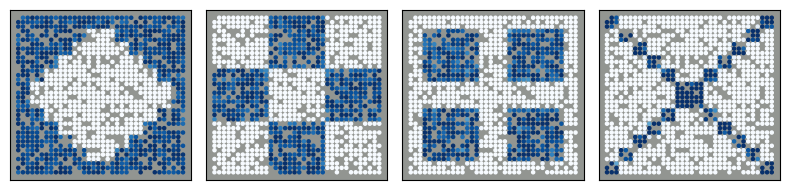

In [39]:
plot_factors(means1[-1], Xtr, moran_idx=None, ax=None, size=2, s=5, alpha=1)

In [40]:
# plot_factors(means2[-1], Xtr, moran_idx=None, ax=None, size=2, s=5, alpha=1)

In [41]:
# plot_factors(means3[-1], Xtr, moran_idx=None, ax=None, size=2, s=5, alpha=1)

In [42]:
# plot_factors(means4[-1], Xtr, moran_idx=None, ax=None, size=2, s=5, alpha=1)

In [43]:
model1.cpu()
Xtest = torch.cartesian_prod(torch.linspace(-2, 2, 34), torch.linspace(-2, 2, 34), )
qF1, _, _ = model1.sf.prior(Xtest)
qF2, _ = model1.cf.prior()
means1_test = torch.exp(qF1.mean).detach().numpy()
means2_test = torch.exp(qF2.mean).detach().numpy()

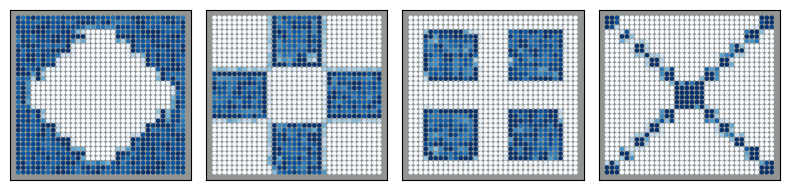

In [44]:
plot_factors(means1_test, Xtest, moran_idx=None, ax=None, size=2, s=5, alpha=1)

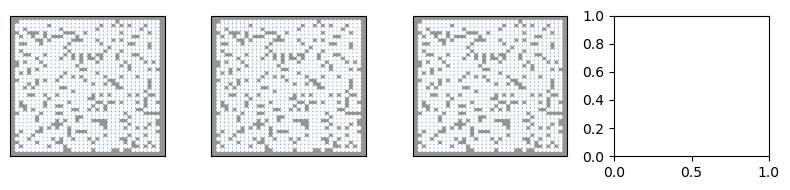

In [45]:
plot_factors(means2_test, X, moran_idx=None, ax=None, size=2, s=5, alpha=1)

hi 0
hi 0
hi 1
hi 2
hi 3
hi 4
hi 5
hi 6
hi 7
hi 8
hi 9
hi 10
hi 11
hi 12
hi 13
hi 14
hi 15
hi 16
hi 17
hi 18
hi 19
hi 20
hi 21
hi 22
hi 23
hi 24
hi 25
hi 26
hi 27
hi 28
hi 29
hi 30
hi 31
hi 32
hi 33
hi 34
hi 35
hi 36
hi 37
hi 38
hi 39
hi 40
hi 41
hi 42
hi 43
hi 44
hi 45
hi 46
hi 47
hi 48
hi 49
hi 50
hi 51
hi 52
hi 53
hi 54
hi 55
hi 56
hi 57
hi 58
hi 59
hi 60
hi 61
hi 62
hi 63
hi 64
hi 65
hi 66
hi 67
hi 68
hi 69
hi 70
hi 71
hi 72
hi 73
hi 74
hi 75
hi 76
hi 77
hi 78
hi 79
hi 80
hi 81
hi 82
hi 83
hi 84
hi 85
hi 86
hi 87
hi 88
hi 89
hi 90
hi 91
hi 92
hi 93
hi 94
hi 95
hi 96
hi 97
hi 98
hi 99
hi 100
hi 101
hi 102
hi 103
hi 104
hi 105
hi 106
hi 107
hi 108
hi 109
hi 110
hi 111
hi 112
hi 113
hi 114
hi 115
hi 116
hi 117
hi 118
hi 119
hi 120
hi 121
hi 122
hi 123
hi 124
hi 125
hi 126
hi 127
hi 128
hi 129
hi 130
hi 131
hi 132
hi 133
hi 134
hi 135
hi 136
hi 137
hi 138
hi 139
hi 140
hi 141
hi 142
hi 143
hi 144
hi 145
hi 146
hi 147
hi 148
hi 149
hi 150
hi 151
hi 152
hi 153
hi 154
hi 155
hi 156
hi 157

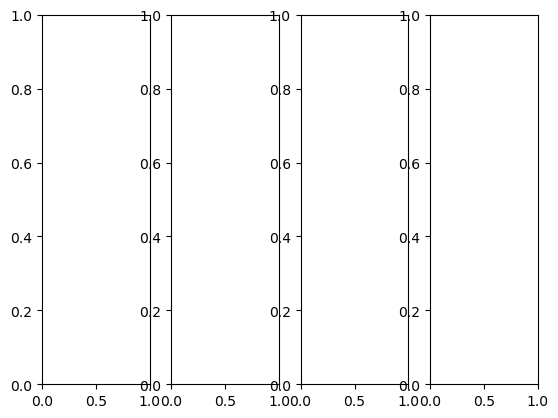

In [69]:
size=2
fig, ax = plt.subplots(4, 4, figsize=(size*4, size*4), tight_layout=True)

def update(iteration):
    for element in ax:
        for element in element:
            element.cla()
        
    curr_factor1 = means1[iteration]
    curr_factor2 = means2[iteration]
    curr_factor3 = means3[iteration]
    curr_factor4 = means4[iteration]
    
    
    plot_factors(curr_factor1,Xtr, ax=ax[0], s=5, alpha=1)
    plot_factors(curr_factor2,Xtr, ax=ax[1], s=5, alpha=1)
    plot_factors(curr_factor3,Xtr, ax=ax[2], s=5, alpha=1)
    plot_factors(curr_factor4,Xtr, ax=ax[3], s=5, alpha=1)
#     fig.suptitle(f"Iteration: {iteration}, Loss: {losses[iteration*10]:0.2f}")
#     fig.tight_layout()
    print('hi', iteration)


anim = FuncAnimation(fig, update, frames=np.arange(0, 1000, 1), interval=100)
plt.close()
# anim.save('pnmf.mp4',
#          writer=animation.FFMpegWriter(fps=50, bitrate=2000, codec='h264'),
#          dpi=50)
anim.save("nsf_toy_all.mp4", fps=40, dpi=100)

hi 0
hi 0
hi 1
hi 2
hi 3
hi 4
hi 5
hi 6
hi 7
hi 8
hi 9
hi 10
hi 11
hi 12
hi 13
hi 14
hi 15
hi 16
hi 17
hi 18
hi 19
hi 20
hi 21
hi 22
hi 23
hi 24
hi 25
hi 26
hi 27
hi 28
hi 29
hi 30
hi 31
hi 32
hi 33
hi 34
hi 35
hi 36
hi 37
hi 38
hi 39
hi 40
hi 41
hi 42
hi 43
hi 44
hi 45
hi 46
hi 47
hi 48
hi 49
hi 50
hi 51
hi 52
hi 53
hi 54
hi 55
hi 56
hi 57
hi 58
hi 59
hi 60
hi 61
hi 62
hi 63
hi 64
hi 65
hi 66
hi 67
hi 68
hi 69
hi 70
hi 71
hi 72
hi 73
hi 74
hi 75
hi 76
hi 77
hi 78
hi 79
hi 80
hi 81
hi 82
hi 83
hi 84
hi 85
hi 86
hi 87
hi 88
hi 89
hi 90
hi 91
hi 92
hi 93
hi 94
hi 95
hi 96
hi 97
hi 98
hi 99
hi 100
hi 101
hi 102
hi 103
hi 104
hi 105
hi 106
hi 107
hi 108
hi 109
hi 110
hi 111
hi 112
hi 113
hi 114
hi 115
hi 116
hi 117
hi 118
hi 119
hi 120
hi 121
hi 122
hi 123
hi 124
hi 125
hi 126
hi 127
hi 128
hi 129
hi 130
hi 131
hi 132
hi 133
hi 134
hi 135
hi 136
hi 137
hi 138
hi 139
hi 140
hi 141
hi 142
hi 143
hi 144
hi 145
hi 146
hi 147
hi 148
hi 149
hi 150
hi 151
hi 152
hi 153
hi 154
hi 155
hi 156
hi 157

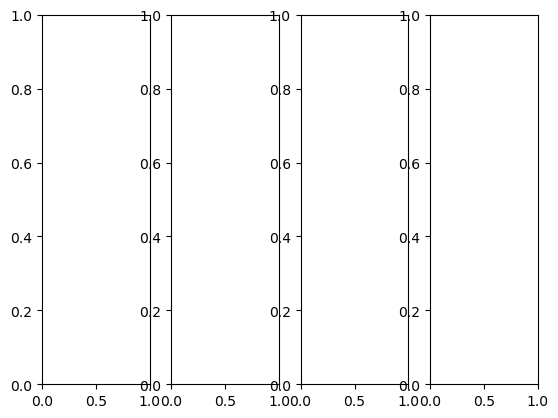

In [32]:
size=2
fig, ax = plt.subplots(1, 4, figsize=(size*4, size), tight_layout=True)

def update(iteration):
    for element in ax:
        element.cla()
        
    curr_factor = means2[iteration]
    
    
    plot_factors(curr_factor,Xtr, ax=ax, s=5, alpha=1)
#     fig.suptitle(f"Iteration: {iteration}, Loss: {losses[iteration*10]:0.2f}")
#     fig.tight_layout()
    print('hi', iteration)


anim = FuncAnimation(fig, update, frames=np.arange(0, 1000, 1), interval=100)
plt.close()
# anim.save('pnmf.mp4',
#          writer=animation.FFMpegWriter(fps=50, bitrate=2000, codec='h264'),
#          dpi=50)
anim.save("nsf_toy2.mp4", fps=40, dpi=100)

hi 0
hi 0
hi 1
hi 2
hi 3
hi 4
hi 5
hi 6
hi 7
hi 8
hi 9
hi 10
hi 11
hi 12
hi 13
hi 14
hi 15
hi 16
hi 17
hi 18
hi 19
hi 20
hi 21
hi 22
hi 23
hi 24
hi 25
hi 26
hi 27
hi 28
hi 29
hi 30
hi 31
hi 32
hi 33
hi 34
hi 35
hi 36
hi 37
hi 38
hi 39
hi 40
hi 41
hi 42
hi 43
hi 44
hi 45
hi 46
hi 47
hi 48
hi 49
hi 50
hi 51
hi 52
hi 53
hi 54
hi 55
hi 56
hi 57
hi 58
hi 59
hi 60
hi 61
hi 62
hi 63
hi 64
hi 65
hi 66
hi 67
hi 68
hi 69
hi 70
hi 71
hi 72
hi 73
hi 74
hi 75
hi 76
hi 77
hi 78
hi 79
hi 80
hi 81
hi 82
hi 83
hi 84
hi 85
hi 86
hi 87
hi 88
hi 89
hi 90
hi 91
hi 92
hi 93
hi 94
hi 95
hi 96
hi 97
hi 98
hi 99
hi 100
hi 101
hi 102
hi 103
hi 104
hi 105
hi 106
hi 107
hi 108
hi 109
hi 110
hi 111
hi 112
hi 113
hi 114
hi 115
hi 116
hi 117
hi 118
hi 119
hi 120
hi 121
hi 122
hi 123
hi 124
hi 125
hi 126
hi 127
hi 128
hi 129
hi 130
hi 131
hi 132
hi 133
hi 134
hi 135
hi 136
hi 137
hi 138
hi 139
hi 140
hi 141
hi 142
hi 143
hi 144
hi 145
hi 146
hi 147
hi 148
hi 149
hi 150
hi 151
hi 152
hi 153
hi 154
hi 155
hi 156
hi 157

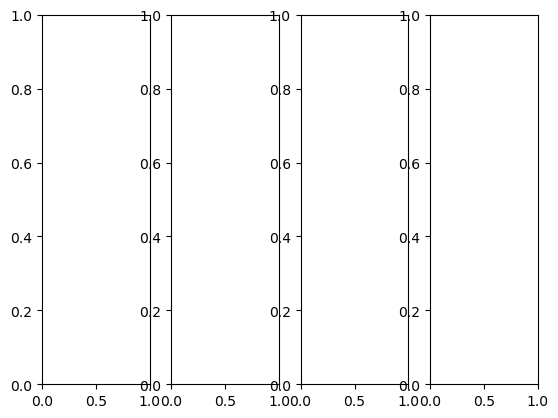

In [33]:
size=2
fig, ax = plt.subplots(1, 4, figsize=(size*4, size), tight_layout=True)

def update(iteration):
    for element in ax:
        element.cla()
        
    curr_factor = means3[iteration]
    
    
    plot_factors(curr_factor,Xtr, ax=ax, s=5, alpha=1)
#     fig.suptitle(f"Iteration: {iteration}, Loss: {losses[iteration*10]:0.2f}")
#     fig.tight_layout()
    print('hi', iteration)


anim = FuncAnimation(fig, update, frames=np.arange(0, 1000, 1), interval=100)
plt.close()
# anim.save('pnmf.mp4',
#          writer=animation.FFMpegWriter(fps=50, bitrate=2000, codec='h264'),
#          dpi=50)
anim.save("nsf_toy3.mp4", fps=40, dpi=100)

hi 0
hi 0
hi 1
hi 2
hi 3
hi 4
hi 5
hi 6
hi 7
hi 8
hi 9
hi 10
hi 11
hi 12
hi 13
hi 14
hi 15
hi 16
hi 17
hi 18
hi 19
hi 20
hi 21
hi 22
hi 23
hi 24
hi 25
hi 26
hi 27
hi 28
hi 29
hi 30
hi 31
hi 32
hi 33
hi 34
hi 35
hi 36
hi 37
hi 38
hi 39
hi 40
hi 41
hi 42
hi 43
hi 44
hi 45
hi 46
hi 47
hi 48
hi 49
hi 50
hi 51
hi 52
hi 53
hi 54
hi 55
hi 56
hi 57
hi 58
hi 59
hi 60
hi 61
hi 62
hi 63
hi 64
hi 65
hi 66
hi 67
hi 68
hi 69
hi 70
hi 71
hi 72
hi 73
hi 74
hi 75
hi 76
hi 77
hi 78
hi 79
hi 80
hi 81
hi 82
hi 83
hi 84
hi 85
hi 86
hi 87
hi 88
hi 89
hi 90
hi 91
hi 92
hi 93
hi 94
hi 95
hi 96
hi 97
hi 98
hi 99
hi 100
hi 101
hi 102
hi 103
hi 104
hi 105
hi 106
hi 107
hi 108
hi 109
hi 110
hi 111
hi 112
hi 113
hi 114
hi 115
hi 116
hi 117
hi 118
hi 119
hi 120
hi 121
hi 122
hi 123
hi 124
hi 125
hi 126
hi 127
hi 128
hi 129
hi 130
hi 131
hi 132
hi 133
hi 134
hi 135
hi 136
hi 137
hi 138
hi 139
hi 140
hi 141
hi 142
hi 143
hi 144
hi 145
hi 146
hi 147
hi 148
hi 149
hi 150
hi 151
hi 152
hi 153
hi 154
hi 155
hi 156
hi 157

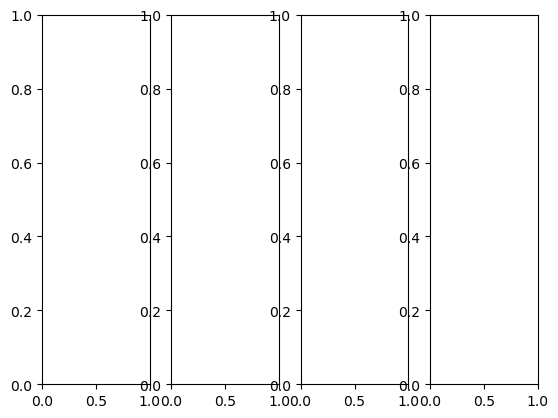

In [34]:
size=2
fig, ax = plt.subplots(1, 4, figsize=(size*4, size), tight_layout=True)

def update(iteration):
    for element in ax:
        element.cla()
        
    curr_factor = means4[iteration]
    
    
    plot_factors(curr_factor,Xtr, ax=ax, s=5, alpha=1)
#     fig.suptitle(f"Iteration: {iteration}, Loss: {losses[iteration*10]:0.2f}")
#     fig.tight_layout()
    print('hi', iteration)


anim = FuncAnimation(fig, update, frames=np.arange(0, 1000, 1), interval=100)
plt.close()
# anim.save('pnmf.mp4',
#          writer=animation.FFMpegWriter(fps=50, bitrate=2000, codec='h264'),
#          dpi=50)
anim.save("nsf_toy4.mp4", fps=40, dpi=100)